Ice Cream and Frozen Dessert sales data from: https://fred.stlouisfed.org/series/IPN31152N

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import fbprophet

In [2]:
df = pd.read_csv('./data/Frozen_Dessert_Production.csv')

In [3]:
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'], yearfirst=True)
df.rename(columns={'IPN31152N':'sales', 'DATE': 'date'}, inplace=True)
df.set_index('date', inplace=True)
df.head()

,sales
date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


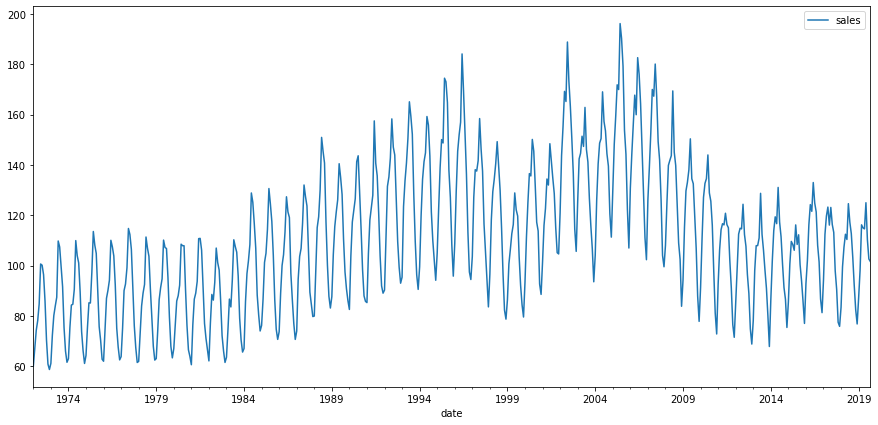

In [5]:
df.plot(figsize=(15, 7))
plt.show()

In [6]:
len(df)

573

In [7]:
test_size = len(df) - 24  # define a 24-month test size
train = df.iloc[:test_size]
test = df.iloc[test_size:]
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [8]:
length = 18  # using 12 months, predict the 13th
n_features = 1  # only 1 feature in the time series
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=1)

In [9]:
model = Sequential()

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# create a validation generator - same as the trianing, but with the testing 18-month period
validation_generator = TimeseriesGenerator(scaled_test,
                                           scaled_test,
                                           length=length,
                                           batch_size=1)

model.fit(generator, epochs=50,
          validation_data=validation_generator,
          callbacks=[early_stop])

Epoch 1/50
531/531 [==============================] - 11s 21ms/step - loss: 0.0249 - val_loss: 0.0034
Epoch 2/50
531/531 [==============================] - 11s 21ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 3/50
531/531 [==============================] - 11s 21ms/step - loss: 0.0049 - val_loss: 0.0073
Epoch 4/50
531/531 [==============================] - 11s 21ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 5/50
531/531 [==============================] - 11s 21ms/step - loss: 0.0033 - val_loss: 0.0025


In [11]:
model_perf = pd.DataFrame(model.history.history)
model_perf

,loss,val_loss
0,0.024860,0.003368
1,0.006059,0.002068
2,0.004906,0.007252
3,0.003596,0.002106
4,0.003302,0.002540


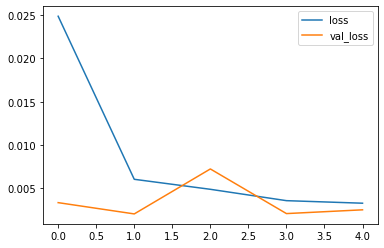

In [12]:
model_perf.plot()
plt.show()

<ipython-input-13-11d1101d078c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = true_predictions


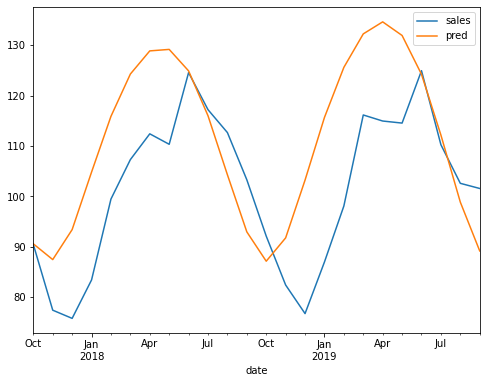

In [13]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [
                              [current_pred]], axis=1)
true_predictions = scaler.inverse_transform(
    test_predictions)  # inverse scale to get actual values
test['pred'] = true_predictions
test.plot(figsize=(8, 6))

# Retrain the model in the complete dataset

In [14]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)
length = 12  # Length of the output sequences (in number of timesteps)
complete_generator = TimeseriesGenerator(
    scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [15]:
model = Sequential()

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(generator, epochs=4)

Epoch 1/4
531/531 [==============================] - 11s 21ms/step - loss: 0.0292
Epoch 2/4
531/531 [==============================] - 11s 21ms/step - loss: 0.0110
Epoch 3/4
531/531 [==============================] - 11s 21ms/step - loss: 0.0049
Epoch 4/4
531/531 [==============================] - 11s 20ms/step - loss: 0.0038


In [17]:
df.tail()

,sales
date,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


In [18]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [
                              [current_pred]], axis=1)

forecast = scaler.inverse_transform(forecast)
forecast_index = pd.date_range(start='2019-09-01',
                               periods=periods, freq='MS')

forecast_df = pd.DataFrame(data=forecast,
                           index=forecast_index,
                           columns=['Forecast'])

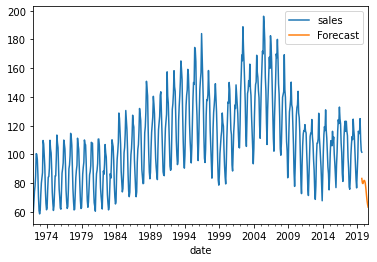

In [19]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

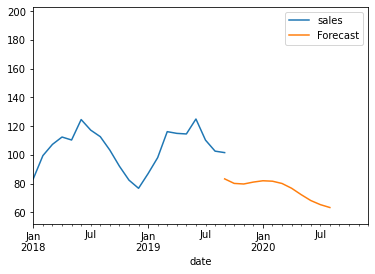

In [20]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')